# This notebook merges rectangular polygons of ocean regions with the latitude and longitude of the cruise locations. The grouped dataset can then be used with FB prophet API in the PhaseIII. FBprophet notebook and other notebooks for visualizations. 

In [2]:
# Install Libraries (This may need to be done first each time the notebook is used here.  Takes a few minutes to install)

  #clean geopandas install
#https://colab.research.google.com/drive/1tSmJmjD3sTI31Cg1UCIKiE10dBUmWUG7#scrollTo=AXNRLO1CixX9
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopandas import GeoSeries
import random
from random import randrange
import geopandas as gpd
from shapely.geometry import Polygon

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
6 packages can be upgraded. Run 'a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv('/content/drive/My Drive/DATA MPS/DATA606/TCO2_filled.csv')
df.drop(columns=[df.columns[0]],inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The dataset is split into ocean regions by the latitude and longitude to have more accurate modeling.**

<br>

<img src='https://www.researchgate.net/profile/Stephanie_Henson/publication/258607947/figure/fig1/AS:392592475869199@1470612748596/Map-of-the-14-ocean-biomes-used-in-the-analysis-1-Highlatitude-North-Pacific-2.png'>


<br><br>
<table>
  <thead>
    <tr>
      <th>Pacific</th>
      <th>Limits</th>
      <th>Atlantic</th>
      <th>Limits</th>
      <th>Indian</th>
      <th>Limits</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>(1) Highlatitude North Pacific</td>
      <td>>45N, 140E-120W</td>
      <td>(6) High-latitude North Atlantic</td>
      <td>45N, 70W-20E</td>
          <td>(11) Arabian Sea</td>
          <td>40N-10S, 20E-80E</td>
    </tr>
    <tr>
      <td>(2) Oligotrophic North Pacific</td>
      <td>10N - 45N, 140E-120W </td>
      <td>(7) Oligotrophic North Atlantic</td>
      <td>45N-0N, 80W-10W</td>
       <td>(12) Bay of Bengal</td>
       <td>40N-10S, 80E-120E</td>
    </tr>
    <tr>
      <td>(3) Equatorial Pacific</td>
      <td>10S-10N, 120E-80W </td>
      <td>(8) Equatorial Atlantic</td>
      <td>0N-10S, 10W-20E </td> 
      <td>(13) Oligotrophic Indian</td>
      <td>10S-30S, 20E-120E</td>
    </tr>
    <tr>
      <td>(4) Oligotrophic South Pacific</td>
      <td>45S-10S, 120E-80W </td>
      <td>(9) Oligotrophic South Atlantic</td>
      <td>10S-30S, 50W-20E</td>
      <td>(14) Southern Ocean Indian</td>
      <td>>10S, 20E-120E</td>
    </tr>
      <tr>
      <td>(5) Southern Ocean Pacific</td>
      <td>45S, 150E-70W</td>
      <td>(10) Southern Ocean Atlantic</td>
      <td>>30S, 70W-20E</td>
      <td></td>
    </tr>
  </tbody>
</table>
<br>
[1] C. Beaulieu et al., “Factors challenging our ability to detect long-term trends in ocean chlorophyll,” BIOGEOSCIENCES, vol. 10, no. 4, pp. 2711–2724, 2013, doi: 10.5194/bg-10-2711-2013.



**Read in an excel with the rectangular boundaries of the ocean regions. The corners are converted to longitude, latitude coordinates using geopandas.**

In [ ]:
#import lat long boundaries from visual inspection of above figure 
bound= pd.read_excel('/content/drive/My Drive/DATA MPS/DATA606/region_bound.xlsx')
bound.drop(columns=[bound.columns[0]],inplace=True) # drop index column 
p=[]
#turn into geopandas df 
bound = gpd.GeoDataFrame(bound)
#make corners of regions 
bound['corner1'] =(gpd.points_from_xy(bound['Max LONG'],bound['Max LAT']))
bound['corner2']= (gpd.points_from_xy(bound['Max LONG'],bound['Min LAT']))
bound['corner3']= (gpd.points_from_xy(bound['Min LONG'],bound['Min LAT']))
bound['corner4']= (gpd.points_from_xy(bound['Min LONG'],bound['Max LAT']))

#Make polygon shapes for the different regions so can filter data points
for i in range(0,len(bound)):
  p.append(Polygon([bound.iloc[i]['corner1'],bound.iloc[i]['corner2'],bound.iloc[i]['corner3'],bound.iloc[i]['corner4']]))

g = GeoSeries(p) # convert to polygon 
bound['geometry'] =g
bound = bound.reset_index()

In [ ]:
# generate some numbers for colors 
bound['plotc'] = np.linspace(1,1000, num=len(bound))
#set up plot colors, the meridian splits the pacific regions (0:5) and (14:19)
k=bound.loc[0:5,'plotc'] 
for i in range(14,19):
  bound.loc[i,'plotc'] = k[i-14]
bound.plotc

0        1.000000
1       53.578947
2      106.157895
3      158.736842
4      211.315789
5      263.894737
6      316.473684
7      369.052632
8      421.631579
9      474.210526
10     526.789474
11     579.368421
12     631.947368
13     684.526316
14       1.000000
15      53.578947
16     106.157895
17     158.736842
18     211.315789
19    1000.000000
Name: plotc, dtype: float64

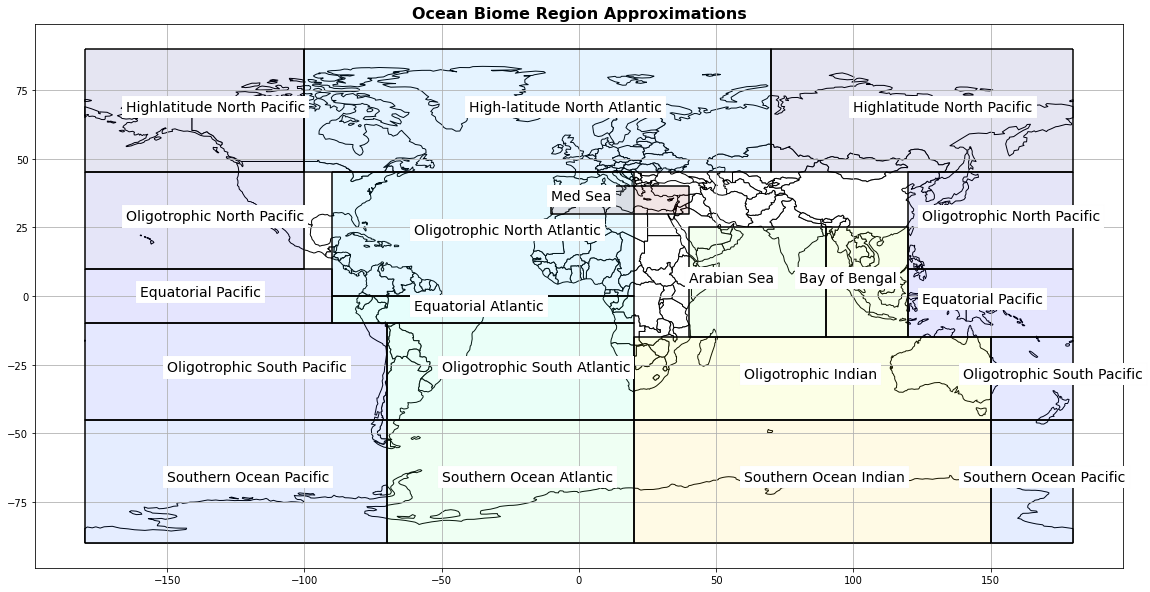

In [ ]:
#make plot of regions 
fig, axe = plt.subplots(figsize=(20, 10))
#base map 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(ax=axe,color='white', edgecolor='black')
#tick marks 
axe.tick_params(axis='both')
axe.grid(which='major',axis='both') #add grid 
bound.geometry.boundary.plot(ax=axe,color='black')#outline
bound.plot(ax=axe,alpha=.1,column='plotc',cmap='jet') #fill 
#add annotatiosn for region instead of key 
#https://stackoverflow.com/questions/53825299/add-labels-to-polygons
for i, geo in bound.geometry.centroid.iteritems():
    axe.annotate(s=bound.iloc[i]['Region'], xy=[geo.x-25, geo.y], color="black",fontsize=14,bbox=dict(fc="w", ec="k", lw=.01))

#gdf.plot(ax=axe)
plt.title('Ocean Biome Region Approximations',fontsize=16,fontweight='bold');

**FB prophet requires a datetime (DS) and a target (Y) column. The dataframe is converted to geopandas df to split into polygon regions**

I used geopandas function spatial join to find what cruise locations are within what ocean region. 

https://geopandas.org/mergingdata.html

In [ ]:
#columns for FBprophet
df['ds'] = df.year.astype(int).astype(str) + "-" +df.month.astype(int).astype(str) + "-" + df.day.astype(int).astype(str)
df['ds'] = pd.to_datetime(df['ds']) # date format for FB prophet 
df['y'] = df.tco2
#change to geodataframe for comparison with polygon regions 
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
#join on if point in cruise is in polygon in the ocean regions group 
gdf = gpd.sjoin(gdf,bound,how="inner",op = 'intersects')
#make plot color 
gdf['colorm'] = gdf['Max LAT'] + gdf['Min LONG'] *gdf['Min LAT']
#drop columns from group data frame 
gdf.drop(columns=['index', 'Max LAT', 'Min LAT', 'Max LONG', 'Min LONG',
       'corner1', 'corner2', 'corner3', 'corner4'],inplace=True)
gdf

,cruise,station,cast,year,month,day,latitude,longitude,bottomdepth,maxsampdepth,pressure,depth,temperature,theta,salinity,sigma0,sigma1,sigma2,sigma3,gamma,oxygen,aou,nitrate,nitrite,silicate,phosphate,talk,phts25p0,phtsinsitutp,tco2,Fill,ds,y,geometry,index_right,Region,plotc,colorm
0,3.0,280.0,1.0,1987.0,7.0,8.0,81.5750,31.5430,1028.0,962.0,15.0,15.0,-1.7196,-1.719900,34.1300,27.471000,32.240000,36.901000,41.457000,27.655570,349.4000,17.206000,9.19000,0.050000,4.010000,0.660000,2342.031,7.693095,8.086513,2058.000,False,1987-07-08,2058.000,POINT (31.54300 81.57500),5,High-latitude North Atlantic,263.894737,3240
1,3.0,280.0,1.0,1987.0,7.0,8.0,81.5750,31.5430,1028.0,962.0,50.1,50.0,-1.0817,-1.083000,34.5250,27.772000,32.517000,37.155000,41.688000,28.011130,345.7000,13.587000,9.48000,0.100000,4.400000,0.710000,2349.692,7.692001,8.071350,2092.000,False,1987-07-08,2092.000,POINT (31.54300 81.57500),5,High-latitude North Atlantic,263.894737,3240
2,3.0,280.0,1.0,1987.0,7.0,8.0,81.5750,31.5430,1028.0,962.0,70.2,69.0,-0.7998,-0.801830,34.6250,27.842000,32.577000,37.206000,41.730000,28.065060,338.9000,17.438000,10.07000,0.140000,4.690000,0.740000,2349.152,7.653776,8.067266,2108.000,False,1987-07-08,2108.000,POINT (31.54300 81.57500),5,High-latitude North Atlantic,263.894737,3240
3,3.0,280.0,1.0,1987.0,7.0,8.0,81.5750,31.5430,1028.0,962.0,90.0,89.0,0.5409,0.537230,34.7730,27.892000,32.587000,37.176000,41.660000,28.072260,289.3252,144.676024,11.04000,0.170000,4.690000,0.770000,2310.804,7.634695,8.062653,2111.000,False,1987-07-08,2111.000,POINT (31.54300 81.57500),5,High-latitude North Atlantic,263.894737,3240
4,3.0,280.0,1.0,1987.0,7.0,8.0,81.5750,31.5430,1028.0,962.0,150.0,148.0,1.3567,1.349500,34.8880,27.931000,32.601000,37.166000,41.628000,28.110800,320.8000,15.552000,11.92000,0.130000,5.180000,0.780000,2304.045,7.749597,8.058611,2107.000,False,1987-07-08,2107.000,POINT (31.54300 81.57500),5,High-latitude North Atlantic,263.894737,3240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218460,2103.0,6313.0,1.0,2018.0,8.0,24.0,10.4907,163.9782,4960.0,4950.0,3978.2,3919.0,1.4638,1.148273,34.6866,27.783519,32.460959,37.033234,41.501955,28.085704,157.6000,181.000670,35.55050,0.000005,141.362261,2.462400,2411.567,7.591974,7.772460,2321.148,True,2018-08-24,2321.148,POINT (163.97820 10.49070),15,Oligotrophic North Pacific,53.578947,1245
1218461,2103.0,6313.0,1.0,2018.0,8.0,24.0,10.4907,163.9782,4960.0,4950.0,4235.5,4170.0,1.4433,1.100044,34.6900,27.789534,32.468330,37.041925,41.511926,28.095310,164.2000,174.807767,35.19970,0.000005,138.799400,2.445754,2409.374,7.594084,7.770975,2315.898,True,2018-08-24,2315.898,POINT (163.97820 10.49070),15,Oligotrophic North Pacific,53.578947,1245
1218462,2103.0,6313.0,1.0,2018.0,8.0,24.0,10.4907,163.9782,4960.0,4950.0,4492.7,4421.0,1.4336,1.061488,34.6932,27.794708,32.474586,37.049234,41.520256,28.103367,169.1000,170.232578,34.83670,0.000604,134.744400,2.410540,2406.364,7.603370,7.765693,2308.717,True,2018-08-24,2308.717,POINT (163.97820 10.49070),15,Oligotrophic North Pacific,53.578947,1245
1218463,2103.0,6313.0,1.0,2018.0,8.0,24.0,10.4907,163.9782,4960.0,4950.0,4748.4,4670.0,1.3808,0.980573,34.6985,27.804369,32.486531,37.063407,41.536587,28.119278,180.0000,160.019762,34.05580,0.001103,129.734900,2.351100,2397.096,7.613136,7.764186,2297.998,True,2018-08-24,2297.998,POINT (163.97820 10.49070),15,Oligotrophic North Pacific,53.578947,1245


Text(0, 0.5, 'Count of DataFrame Rows')

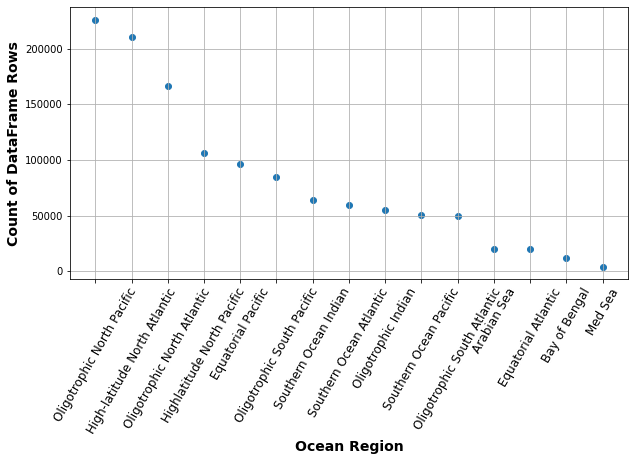

In [ ]:
fig, axe = plt.subplots(figsize=(10, 5))
plt.scatter(gdf.Region.value_counts().index,gdf.Region.value_counts())
plt.xticks(rotation=60,fontsize = 12)
plt.grid(axis='both')
plt.xlabel('Ocean Region',fontsize=14,fontweight='bold')
plt.ylabel('Count of DataFrame Rows',fontsize=14,fontweight='bold')

**Show cruise locations for each region**


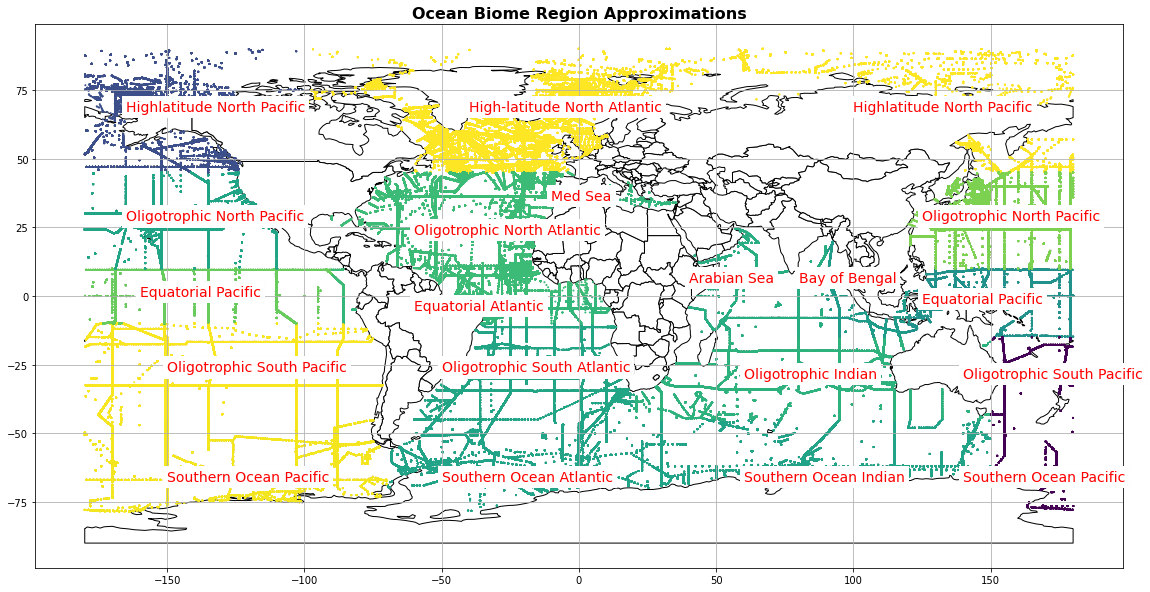

In [ ]:
#make plot of regions 
fig, axe = plt.subplots(figsize=(20, 10))
#base map 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(ax=axe,color='white', edgecolor='black')
#tick marks 
axe.tick_params(axis='both')
axe.grid(which='major',axis='both') #add grid 
#add annotatiosn for region instead of key 
#https://stackoverflow.com/questions/53825299/add-labels-to-polygons
for i, geo in bound.geometry.centroid.iteritems():
    axe.annotate(s=bound.iloc[i]['Region'], xy=[geo.x-25, geo.y], color="red",fontsize=14,bbox=dict(fc="w", ec="k", lw=.01))
gdf.plot(ax=axe,column='colorm',markersize = 1)
#gdf.plot(ax=axe)
plt.title('Ocean Biome Region Approximations',fontsize=16,fontweight='bold');

**Split (too large to save to one file) and save this dataframe to drive**


In [ ]:
gdf[0:int((len(gdf)/2)+.5)].to_excel('/content/drive/My Drive/DATA MPS/DATA606/MergedPoly1.xlsx')
gdf[int((len(gdf)/2)+.5):len(gdf)].to_excel('/content/drive/My Drive/DATA MPS/DATA606/MergedPoly2.xlsx')

In [ ]:
for ocean, df in gdf.groupby(['Region']): 
  print(ocean,df)
i = gdf.groupby(['Region'])
k =i.get_group('Arabian Sea')

k

Arabian Sea         cruise  station  cast  ...       Region       plotc  colorm
51399    250.0    260.0   1.0  ...  Arabian Sea  526.789474    -575
51400    250.0    260.0   1.0  ...  Arabian Sea  526.789474    -575
51401    250.0    260.0   1.0  ...  Arabian Sea  526.789474    -575
51402    250.0    260.0   1.0  ...  Arabian Sea  526.789474    -575
51403    250.0    260.0   1.0  ...  Arabian Sea  526.789474    -575
...        ...      ...   ...  ...          ...         ...     ...
583354   371.0     67.0   1.0  ...  Arabian Sea  526.789474    -575
583355   371.0     67.0   1.0  ...  Arabian Sea  526.789474    -575
583356   371.0     67.0   1.0  ...  Arabian Sea  526.789474    -575
583357   371.0     67.0   1.0  ...  Arabian Sea  526.789474    -575
585487   383.0     26.0   1.0  ...  Arabian Sea  526.789474    -575

[19762 rows x 38 columns]
Bay of Bengal          cruise  station  cast  ...         Region       plotc  colorm
46362      82.0     43.0   1.0  ...  Bay of Bengal  579.3684

,cruise,station,cast,year,month,day,latitude,longitude,bottomdepth,maxsampdepth,pressure,depth,temperature,theta,salinity,sigma0,sigma1,sigma2,sigma3,gamma,oxygen,aou,nitrate,nitrite,silicate,phosphate,talk,phts25p0,phtsinsitutp,tco2,Fill,ds,y,geometry,index_right,Region,plotc,colorm
51399,250.0,260.0,1.0,1995.0,2.0,26.0,15.135,89.936,2714.0,2704.0,11.4,11.0,25.0850,25.0830,31.718,20.840,25.059,29.185,33.222,20.694,213.10000,-2.18840,0.05000,0.000000,3.460000,0.040000,2154.000,7.947281,7.994536,1845.900,False,1995-02-26,1845.900,POINT (89.93600 15.13500),10,Arabian Sea,526.789474,-575
51400,250.0,260.0,1.0,1995.0,2.0,26.0,15.135,89.936,2714.0,2704.0,27.2,27.0,24.3650,24.3600,31.836,21.144,25.372,29.506,33.552,20.990,216.70000,-3.35470,0.05000,0.000000,3.230000,0.040000,2161.800,7.905132,7.979604,1850.700,False,1995-02-26,1850.700,POINT (89.93600 15.13500),10,Arabian Sea,526.789474,-575
51401,250.0,260.0,1.0,1995.0,2.0,26.0,15.135,89.936,2714.0,2704.0,52.2,52.0,24.8100,24.7980,32.625,21.610,25.827,29.952,33.987,21.484,208.00000,2.68860,0.09000,0.000000,3.000000,0.070000,2187.700,7.944213,7.988760,1873.300,False,1995-02-26,1873.300,POINT (89.93600 15.13500),10,Arabian Sea,526.789474,-575
51402,250.0,260.0,1.0,1995.0,2.0,26.0,15.135,89.936,2714.0,2704.0,68.0,68.0,25.7820,25.7670,33.142,21.706,25.907,30.017,34.038,21.604,189.10000,17.51200,0.64000,0.260000,2.970000,0.180000,2208.600,8.048903,8.051023,1900.500,False,1995-02-26,1900.500,POINT (89.93600 15.13500),10,Arabian Sea,526.789474,-575
51403,250.0,260.0,1.0,1995.0,2.0,26.0,15.135,89.936,2714.0,2704.0,85.0,84.0,25.6180,25.5990,34.548,22.818,27.014,31.117,35.133,22.764,50.00000,155.33000,16.07000,0.160000,9.670000,1.250000,2261.600,8.027213,8.021453,2075.600,False,1995-02-26,2075.600,POINT (89.93600 15.13500),10,Arabian Sea,526.789474,-575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583354,371.0,67.0,1.0,1989.0,9.0,7.0,0.000,86.290,4532.0,1008.5,151.8,151.0,15.6060,15.5820,35.159,25.966,30.310,34.559,38.714,26.022,96.44191,166.75328,20.94585,0.015700,13.394551,1.443456,2312.072,7.733504,7.855198,2164.085,True,1989-09-07,2164.085,POINT (86.29000 0.00000),10,Arabian Sea,526.789474,-575
583355,371.0,67.0,1.0,1989.0,9.0,7.0,0.000,86.290,4532.0,1008.5,201.2,200.0,12.9880,12.9600,35.107,26.484,30.878,35.174,39.376,26.553,81.62966,183.03080,26.25890,0.002500,21.203748,1.738798,2311.911,7.666910,7.831548,2193.813,True,1989-09-07,2193.813,POINT (86.29000 0.00000),10,Arabian Sea,526.789474,-575
583356,371.0,67.0,1.0,1989.0,9.0,7.0,0.000,86.290,4532.0,1008.5,1008.5,1001.0,6.6030,6.5061,34.919,27.423,31.958,36.391,40.725,27.513,68.72600,239.89120,36.29783,0.004801,84.125040,2.720119,2351.198,7.501549,7.719950,2298.596,True,1989-09-07,2298.596,POINT (86.29000 0.00000),10,Arabian Sea,526.789474,-575
583357,371.0,67.0,1.0,1989.0,9.0,7.0,0.000,86.290,4532.0,1008.5,1008.5,1001.0,6.6030,6.5061,34.920,27.424,31.958,36.392,40.726,27.514,68.72600,239.98730,36.29783,0.004801,84.125210,2.720119,2351.329,7.501549,7.720211,2298.669,True,1989-09-07,2298.669,POINT (86.29000 0.00000),10,Arabian Sea,526.789474,-575
